In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ---- SETUP ENVIRONMENT ----
!pip install --upgrade pip
!pip install tensorflow pillow numpy matplotlib scikit-learn opencv-python tqdm ultralytics deep_sort_realtime mediapipe


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os


# Importing the content of google drive to local collab storage for faster training

In [ ]:
# ============================================================
# COPY DATASET FROM DRIVE TO COLAB LOCAL STORAGE
# ============================================================

from google.colab import drive
import shutil
import os

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Define paths
drive_dataset_path = "/content/drive/MyDrive/skeleton_dataset"  # your folder in Drive
local_dataset_path = "/content/skeleton_dataset"                 # Colab local storage

# 3️⃣ Remove local folder if it exists (optional, prevents duplication)
if os.path.exists(local_dataset_path):
    shutil.rmtree(local_dataset_path)

# 4️⃣ Copy entire dataset
shutil.copytree(drive_dataset_path, local_dataset_path)

print(f"✅ Dataset copied to {local_dataset_path}")


# ResNet50v2 Training

In [ ]:

#>>>>>>>>>>>>>>>>>>>>>>>>>>>ResNet Training Code <<<<<<<<<<<<<<<<<<<<<
# ============================================================
# CONFIG
# ============================================================
TRAIN_PATH = "/content/skeleton_dataset/Second_training_dataset/resnet50v2_training_dataset/training_dataset"
VAL_PATH   = "/content/skeleton_dataset/Second_training_dataset/resnet50v2_training_dataset/validation_dataset"

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_HEAD = 12
EPOCHS_FINE = 25

# ============================================================
# DATA PIPELINE
# ============================================================
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.08,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# ============================================================
# MODEL
# ============================================================
base_model = ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze backbone
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

embedding = Dense(512, activation="relu", name="embedding")(x)
x = Dropout(0.3)(embedding)

output = Dense(1, activation="sigmoid", name="classifier")(x)

model = Model(inputs=base_model.input, outputs=output)

# ============================================================
# CALLBACKS
# ============================================================
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(
        "/content/drive/MyDrive/resnet50v2_best.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

# ============================================================
# STEP 1 — HEAD TRAINING
# ============================================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
)

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks,
    class_weight={0: 1.0, 1: 1.3}
)

# ============================================================
# STEP 2 — FINE-TUNING (conv5 only, BN frozen)
# ============================================================
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    elif layer.name.startswith("conv5"):
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
)

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE,
    callbacks=callbacks,
    class_weight={0: 1.0, 1: 1.3}
)

# ============================================================
# SAVE FINAL MODEL (FOR LSTM FEATURE EXTRACTION)
# ============================================================
model.save("/content/drive/MyDrive/resnet50v2_final.keras")

print("🔥 Training completed successfully 🔥")
model.summary()



#ResNet50v2 Evaluations (Quantitative Metrics and Confusion Matrix)
##Auto-Save in /content/drive/MyDrive/evaluation


In [ ]:
# ================================
#  RESNET COMPLETE EVALUATION CELL
# ================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    accuracy_score
)

# ----------------------------
# Paths
# ----------------------------
MODEL_PATH = "/content/drive/MyDrive/resnet50v2_best.keras"  # best checkpoint
SAVE_DIR   = "/content/drive/MyDrive/evaluation"
os.makedirs(SAVE_DIR, exist_ok=True)

# ----------------------------
# Load trained model
# ----------------------------
model = load_model(MODEL_PATH)
print("✅ Model loaded.")

# ----------------------------
# Predict on validation set (fast)
# ----------------------------
# Make sure val_gen was created with shuffle=False
y_prob = model.predict(val_gen, verbose=1)  # predicts all batches efficiently
y_prob = y_prob.squeeze()

# Ground truth labels
y_true = val_gen.classes

# Binary predictions
y_pred = (y_prob >= 0.5).astype(int)

# ----------------------------
# Metrics
# ----------------------------
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
accuracy  = accuracy_score(y_true, y_pred)
auc       = roc_auc_score(y_true, y_prob)

print("===== METRICS =====")
print(f"Recall    : {recall:.4f}  <-- MOST IMPORTANT")
print(f"Precision : {precision:.4f}")
print(f"AUC       : {auc:.4f}")
print(f"Accuracy  : {accuracy:.4f}  (least important)")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Suspicious"]))

# ----------------------------
# Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Suspicious"],
    yticklabels=["Normal", "Suspicious"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/confusion_matrix.png", dpi=300)
plt.show()

# ----------------------------
# ROC Curve
# ----------------------------
fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/roc_curve.png", dpi=300)
plt.show()

# ----------------------------
# Training Convergence (per-epoch metrics)
# ----------------------------
if "history" in globals():
    metrics = ["loss", "precision", "recall", "auc"]
    val_metrics = ["val_loss", "val_precision", "val_recall", "val_auc"]

    for m, vm in zip(metrics, val_metrics):
        plt.figure(figsize=(7,5))
        plt.plot(history.history[m], label=f"Train {m}")
        plt.plot(history.history[vm], label=f"Val {m}")
        plt.xlabel("Epoch")
        plt.ylabel(m)
        plt.title(f"{m.capitalize()} Convergence")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/{m}_convergence.png", dpi=300)
        plt.show()
else:
    print("⚠️ History object not found — cannot plot per-epoch metrics.")

print(f"\n✅ All evaluation plots saved to: {SAVE_DIR}")


#LSTM TRAINING
##Loading lstm_dataset and resnet50v2_best.keras in local collab storage for faster training

In [ ]:
from google.colab import drive
import shutil


# Copy from Drive to local paths
shutil.copytree('/content/drive/MyDrive/lstm_dataset', '/content/lstm_dataset')
shutil.copy('/content/drive/MyDrive/resnet50v2_best.keras', '/content/resnet50v2_best.keras')

'/content/resnet50v2_best.keras'

In [ ]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pickle
from tqdm import tqdm
import warnings

🔍 GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

LOADING RESNET50V2 MODEL AND CREATING FEATURE EXTRACTOR
✅ Loaded ResNet50V2 model from: /content/resnet50v2_best.keras
✅ Feature extractor created
   Feature dimension: 512

STEP 1: LOADING SEQUENCES FROM DATASET

📂 Processing NORMAL class:
  ✅ video_01/student_0: 605 frames → 120 sequences
  ✅ video_01/student_1: 608 frames → 120 sequences
  ✅ video_01/student_2: 605 frames → 120 sequences
  ✅ video_02/student_0: 585 frames → 116 sequences
  ✅ video_02/student_1: 616 frames → 122 sequences
  ✅ video_02/student_2: 357 frames → 70 sequences
  ✅ video_03/student_0: 599 frames → 118 sequences
  ✅ video_03/student_1: 592 frames → 117 sequences
  ✅ video_03/student_2: 113 frames → 21 sequences
  ✅ video_04/student_0: 634 frames → 125 sequences
  ✅ video_04/student_1: 654 frames → 129 sequences
  ✅ video_04/student_2: 707 frames → 140 sequences

📂 Processing SUSPICIOUS class:
  ✅ video_01/student_0: 771 frames

Extracting features: 100%|██████████| 2518/2518 [34:15<00:00,  1.22it/s]



✅ Feature extraction complete!
   Feature array shape: (2518, 10, 512)
   Labels shape: (2518,)

STEP 3: SPLITTING DATA
📊 Dataset split:
   Train: 1510 sequences (60.0%)
   Val:   504 sequences (20.0%)
   Test:  504 sequences (20.0%)

📊 Class distribution in training set:
   Normal: 790 (52.3%)
   Suspicious: 720 (47.7%)

⚖️ Class weights: {0: np.float64(0.9556962025316456), 1: np.float64(1.0486111111111112)}

STEP 4: BUILDING OPTIMIZED LSTM MODEL


Model: "Optimized_LSTM_Behavior_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_normalization             │ (None, 10, 512)        │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 10, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 10, 512)        │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 10, 256)        │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 10, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,408,577 (9.19 MB)

 Trainable params: 2,408,577 (9.19 MB)

 Non-trainable params: 0 (0.00 B)


✅ Model compiled successfully!

STEP 5: SETTING UP TRAINING CALLBACKS
✅ Callbacks configured

STEP 6: TRAINING LSTM MODEL
Training configuration:
   Batch size: 32
   Max epochs: 100
   Initial learning rate: 0.001
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8760 - auc: 0.9423 - loss: 21.2749 - precision: 0.9187 - recall: 0.7903
Epoch 1: val_auc improved from -inf to 0.99725, saving model to /content/drive/MyDrive/lstm_training_results/lstm_best.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.8771 - auc: 0.9430 - loss: 21.1457 - precision: 0.9192 - recall: 0.7927 - val_accuracy: 0.9504 - val_auc: 0.9972 - val_loss: 5.2095 - val_precision: 0.9909 - val_recall: 0.9042 - learning_rate: 0.0010
Epoch 2/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9539 - auc: 0.9896 - loss: 3.8233 - precision: 0.9510 - recall: 0.9500
Epoch 2: val_auc improved from 0.99725 to 0.99828, saving model to /content/drive/MyDrive/lstm_training_results/lstm_best.keras


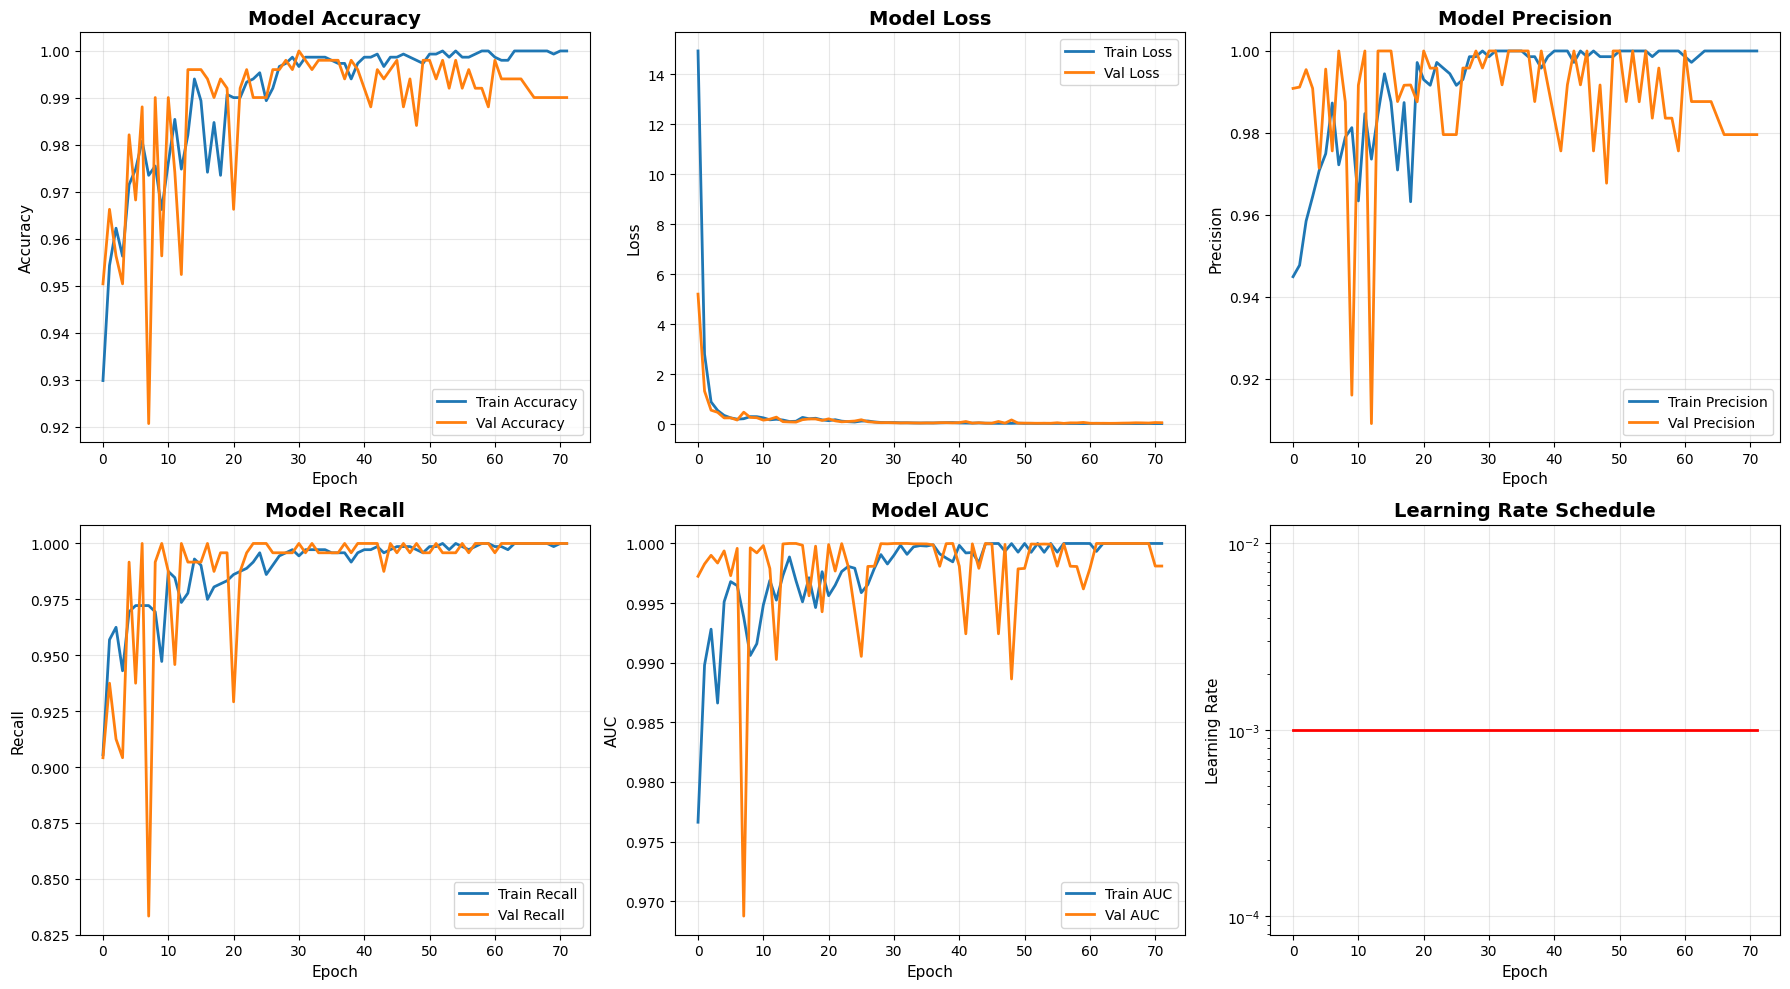


✅ TRAINING COMPLETE!

📁 Training results saved to: /content/drive/MyDrive/lstm_training_results

Files created:
  ✅ lstm_best.keras
  ✅ training_history.pkl
  ✅ training_log.csv
  ✅ training_history.png

⚠️ Run the EVALUATION cell to test the model on the test set


In [ ]:
# ===================== GOOGLE COLAB - LSTM TRAINING =====================
# ===================== IMPORTS =====================
import os
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ===================== CONFIGURATION =====================
DRIVE_OUTPUT_PATH = "/content/drive/MyDrive/lstm_training_results"
LOCAL_DATASET_PATH = "/content/lstm_dataset"
LOCAL_RESNET_PATH = "/content/resnet50v2_best.keras"

SEQUENCE_LENGTH = 10
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

# ===================== CHECK GPU =====================
print("🔍 GPU devices:", tf.config.list_physical_devices('GPU'))

# ===================== LOAD RESNET50V2 & CREATE FEATURE EXTRACTOR =====================
print("\n" + "="*70)
print("LOADING RESNET50V2 MODEL AND CREATING FEATURE EXTRACTOR")
print("="*70)

# Load the pre-trained ResNet50V2 model
resnet_model = keras.models.load_model(LOCAL_RESNET_PATH)
print(f"✅ Loaded ResNet50V2 model from: {LOCAL_RESNET_PATH}")

# Create feature extractor (remove the classification head)
# This extracts features from the layer before the final classification layer
feature_extractor = keras.Model(
    inputs=resnet_model.input,
    outputs=resnet_model.layers[-2].output  # Second-to-last layer
)

# Get the feature dimension
feature_dim = feature_extractor.output.shape[-1]
print(f"✅ Feature extractor created")
print(f"   Feature dimension: {feature_dim}")
print("="*70)

# ===================== STEP 1: LOAD SEQUENCES =====================
print("\n" + "="*70)
print("STEP 1: LOADING SEQUENCES FROM DATASET")
print("="*70)

def load_sequences(dataset_root, sequence_length=10):
    sequences = []
    labels = []

    label_map = {"normal": 0, "suspicious": 1}

    for label_name in ["normal", "suspicious"]:
        label_path = os.path.join(dataset_root, label_name)
        if not os.path.exists(label_path):
            print(f"⚠️ Path not found: {label_path}")
            continue

        video_dirs = sorted([d for d in os.listdir(label_path)
                            if os.path.isdir(os.path.join(label_path, d))])

        print(f"\n📂 Processing {label_name.upper()} class:")
        for video_dir in video_dirs:
            video_path = os.path.join(label_path, video_dir)

            student_dirs = sorted([d for d in os.listdir(video_path)
                                  if os.path.isdir(os.path.join(video_path, d))])

            for student_dir in student_dirs:
                student_path = os.path.join(video_path, student_dir)

                frame_files = sorted([f for f in os.listdir(student_path)
                                     if f.endswith('.png')])

                if len(frame_files) < sequence_length:
                    continue

                step = sequence_length // 2
                num_sequences = 0
                for start_idx in range(0, len(frame_files) - sequence_length + 1, step):
                    sequence_frames = frame_files[start_idx:start_idx + sequence_length]

                    sequence_paths = [
                        os.path.join(student_path, f) for f in sequence_frames
                    ]

                    sequences.append(sequence_paths)
                    labels.append(label_map[label_name])
                    num_sequences += 1

                print(f"  ✅ {video_dir}/{student_dir}: {len(frame_files)} frames → {num_sequences} sequences")

    return sequences, labels

sequences, labels = load_sequences(LOCAL_DATASET_PATH, SEQUENCE_LENGTH)

print(f"\n" + "="*70)
print(f"✅ Total sequences loaded: {len(sequences)}")
print(f"   - Normal: {labels.count(0)} sequences")
print(f"   - Suspicious: {labels.count(1)} sequences")
print("="*70)

if len(sequences) == 0:
    raise ValueError("No sequences loaded! Check your dataset structure.")

# ===================== STEP 2: EXTRACT FEATURES =====================
print("\n" + "="*70)
print("STEP 2: EXTRACTING FEATURES FROM SEQUENCES")
print("="*70)

def extract_features_from_sequence(sequence_paths, feature_extractor):
    features = []

    for img_path in sequence_paths:
        img = keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        feature = feature_extractor.predict(img_array, verbose=0)
        features.append(feature[0])

    return np.array(features)

X = []
y = np.array(labels)

print(f"Processing {len(sequences)} sequences...")
for idx in tqdm(range(len(sequences)), desc="Extracting features"):
    features = extract_features_from_sequence(sequences[idx], feature_extractor)
    X.append(features)

X = np.array(X)
print(f"\n✅ Feature extraction complete!")
print(f"   Feature array shape: {X.shape}")
print(f"   Labels shape: {y.shape}")

# ===================== STEP 3: TRAIN/VAL/TEST SPLIT =====================
print("\n" + "="*70)
print("STEP 3: SPLITTING DATA")
print("="*70)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"📊 Dataset split:")
print(f"   Train: {len(X_train)} sequences ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Val:   {len(X_val)} sequences ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test:  {len(X_test)} sequences ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n📊 Class distribution in training set:")
print(f"   Normal: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"   Suspicious: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")

# ===================== COMPUTE CLASS WEIGHTS =====================
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"\n⚖️ Class weights: {class_weight_dict}")

# ===================== STEP 4: BUILD LSTM MODEL =====================
print("\n" + "="*70)
print("STEP 4: BUILDING OPTIMIZED LSTM MODEL")
print("="*70)

def build_optimized_lstm_model(sequence_length, feature_dim):
    model = keras.Sequential([
        layers.Input(shape=(sequence_length, feature_dim)),

        layers.LayerNormalization(),

        layers.Bidirectional(layers.LSTM(256, return_sequences=True,
                                         kernel_regularizer=keras.regularizers.l2(0.01))),
        layers.Dropout(0.5),
        layers.LayerNormalization(),

        layers.Bidirectional(layers.LSTM(128, return_sequences=True,
                                         kernel_regularizer=keras.regularizers.l2(0.01))),
        layers.Dropout(0.5),
        layers.LayerNormalization(),

        layers.Bidirectional(layers.LSTM(64,
                                         kernel_regularizer=keras.regularizers.l2(0.01))),
        layers.Dropout(0.5),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(1, activation='sigmoid')
    ], name='Optimized_LSTM_Behavior_Classifier')

    return model

lstm_model = build_optimized_lstm_model(SEQUENCE_LENGTH, feature_dim)
lstm_model.summary()

# ===================== COMPILE MODEL =====================
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

print("\n✅ Model compiled successfully!")

# ===================== STEP 5: SETUP CALLBACKS =====================
print("\n" + "="*70)
print("STEP 5: SETTING UP TRAINING CALLBACKS")
print("="*70)

os.makedirs(DRIVE_OUTPUT_PATH, exist_ok=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(DRIVE_OUTPUT_PATH, 'lstm_best.keras'),
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.CSVLogger(
        os.path.join(DRIVE_OUTPUT_PATH, 'training_log.csv'),
        separator=',',
        append=False
    )
]

print("✅ Callbacks configured")

# ===================== STEP 6: TRAIN MODEL =====================
print("\n" + "="*70)
print("STEP 6: TRAINING LSTM MODEL")
print("="*70)
print(f"Training configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Max epochs: {EPOCHS}")
print(f"   Initial learning rate: {LEARNING_RATE}")
print("="*70)

history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# ===================== SAVE TRAINING HISTORY =====================
with open(os.path.join(DRIVE_OUTPUT_PATH, 'training_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)
print(f"\n✅ Training history saved")

# ===================== PLOT TRAINING HISTORY =====================
print("\n" + "="*70)
print("GENERATING TRAINING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = [('accuracy', 'val_accuracy', 'Accuracy'),
           ('loss', 'val_loss', 'Loss'),
           ('precision', 'val_precision', 'Precision'),
           ('recall', 'val_recall', 'Recall'),
           ('auc', 'val_auc', 'AUC')]

for idx, (train_metric, val_metric, title) in enumerate(metrics):
    row = idx // 3
    col = idx % 3

    axes[row, col].plot(history.history[train_metric], label=f'Train {title}', linewidth=2)
    axes[row, col].plot(history.history[val_metric], label=f'Val {title}', linewidth=2)
    axes[row, col].set_title(f'Model {title}', fontsize=14, fontweight='bold')
    axes[row, col].set_xlabel('Epoch', fontsize=11)
    axes[row, col].set_ylabel(title, fontsize=11)
    axes[row, col].legend(fontsize=10)
    axes[row, col].grid(True, alpha=0.3)

lr_history = history.history.get('lr', [LEARNING_RATE] * len(history.history['loss']))
axes[1, 2].plot(lr_history, linewidth=2, color='red')
axes[1, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Epoch', fontsize=11)
axes[1, 2].set_ylabel('Learning Rate', fontsize=11)
axes[1, 2].set_yscale('log')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(DRIVE_OUTPUT_PATH, 'training_history.png'), dpi=300, bbox_inches='tight')
print("✅ Training history plot saved")
plt.show()

# ===================== TRAINING COMPLETE =====================
print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)
print(f"\n📁 Training results saved to: {DRIVE_OUTPUT_PATH}")
print("\nFiles created:")
print("  ✅ lstm_best.keras")
print("  ✅ training_history.pkl")
print("  ✅ training_log.csv")
print("  ✅ training_history.png")
print("\n⚠️ Run the EVALUATION cell to test the model on the test set")
print("="*70)

#LSTM Evaluations (Quantitative Metrics and Confusion Matrix)
## Auto-Save in /content/drive/MyDrive/lstm_training_result


STEP 7: EVALUATING ON TEST SET
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0300 - precision: 1.0000 - recall: 1.0000

TEST SET RESULTS:
Loss.................................... 0.0300
Compile_metrics......................... 1.0000

✅ Test results saved to: /content/drive/MyDrive/lstm_training_results/test_results.txt

STEP 8: GENERATING CONFUSION MATRIX
✅ Confusion matrix saved


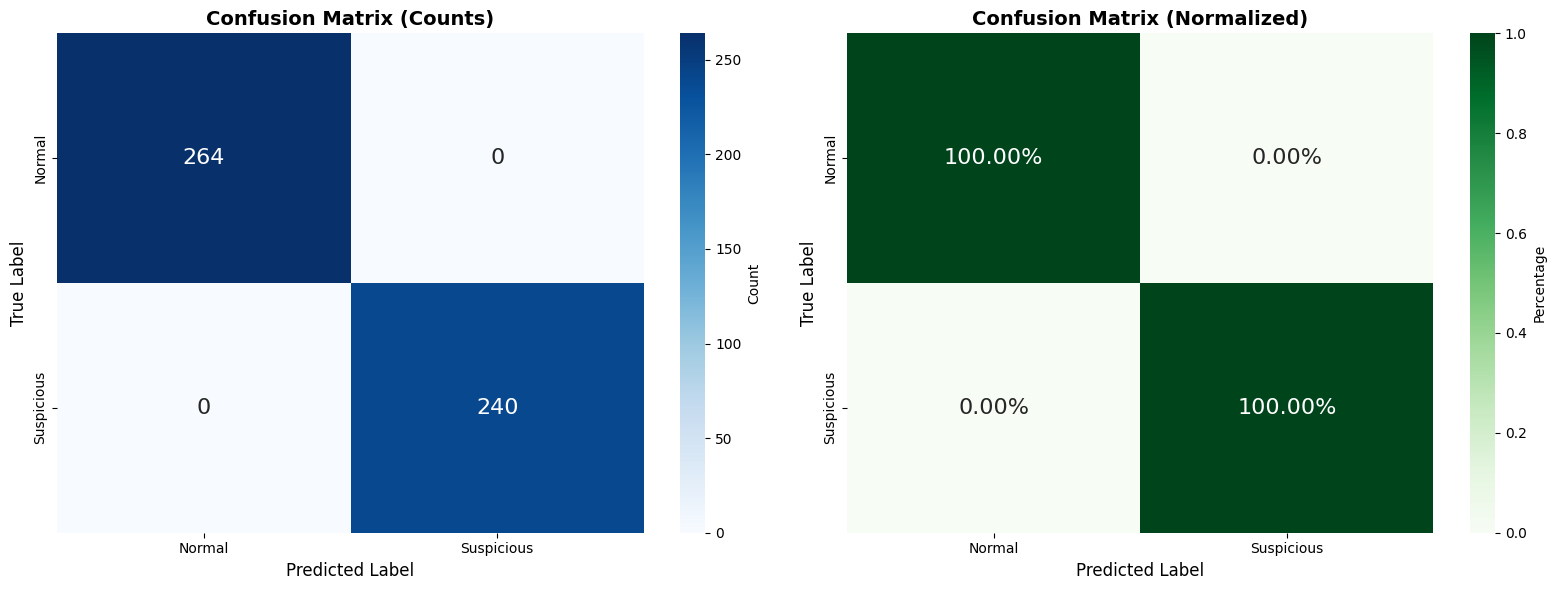


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       264
  Suspicious       1.00      1.00      1.00       240

    accuracy                           1.00       504
   macro avg       1.00      1.00      1.00       504
weighted avg       1.00      1.00      1.00       504

✅ Classification report saved

📊 FINAL MODEL PERFORMANCE:
Accuracy:     1.0000
Precision:    1.0000
Recall:       1.0000
Specificity:  1.0000
F1-Score:     1.0000

✅ Detailed metrics saved

✅ EVALUATION COMPLETE!

📁 All results saved to: /content/drive/MyDrive/lstm_training_results

All files created:
  ✅ lstm_best.keras
  ✅ training_history.pkl
  ✅ training_log.csv
  ✅ training_history.png
  ✅ test_results.txt
  ✅ confusion_matrix.png
  ✅ classification_report.txt
  ✅ detailed_metrics.txt


In [ ]:
# ===================== EVALUATION CELL - RUN AFTER TRAINING =====================
# ===================== STEP 7: EVALUATE ON TEST SET =====================
print("\n" + "="*70)
print("STEP 7: EVALUATING ON TEST SET")
print("="*70)

test_results = lstm_model.evaluate(X_test, y_test, verbose=1)

print("\n" + "="*60)
print("TEST SET RESULTS:")
print("="*60)
for metric_name, value in zip(lstm_model.metrics_names, test_results):
    print(f"{metric_name.capitalize():.<40} {value:.4f}")
print("="*60)

test_results_dict = dict(zip(lstm_model.metrics_names, test_results))
with open(os.path.join(DRIVE_OUTPUT_PATH, 'test_results.txt'), 'w') as f:
    f.write("="*60 + "\n")
    f.write("TEST SET RESULTS\n")
    f.write("="*60 + "\n")
    for metric_name, value in test_results_dict.items():
        f.write(f"{metric_name.capitalize()}: {value:.4f}\n")

print(f"\n✅ Test results saved to: {os.path.join(DRIVE_OUTPUT_PATH, 'test_results.txt')}")

# ===================== STEP 8: CONFUSION MATRIX =====================
print("\n" + "="*70)
print("STEP 8: GENERATING CONFUSION MATRIX")
print("="*70)

y_pred_prob = lstm_model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Suspicious'],
            yticklabels=['Normal', 'Suspicious'],
            ax=axes[0], cbar_kws={'label': 'Count'},
            annot_kws={'size': 16})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=['Normal', 'Suspicious'],
            yticklabels=['Normal', 'Suspicious'],
            ax=axes[1], cbar_kws={'label': 'Percentage'},
            annot_kws={'size': 16})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(DRIVE_OUTPUT_PATH, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
print("✅ Confusion matrix saved")
plt.show()

# ===================== STEP 9: CLASSIFICATION REPORT =====================
print("\n" + "="*60)
print("CLASSIFICATION REPORT:")
print("="*60)
class_report = classification_report(y_test, y_pred,
                                     target_names=['Normal', 'Suspicious'])
print(class_report)
print("="*60)

with open(os.path.join(DRIVE_OUTPUT_PATH, 'classification_report.txt'), 'w') as f:
    f.write("="*60 + "\n")
    f.write("CLASSIFICATION REPORT\n")
    f.write("="*60 + "\n")
    f.write(class_report)

print(f"✅ Classification report saved")

# ===================== STEP 10: FINAL METRICS =====================
print("\n" + "="*70)
print("📊 FINAL MODEL PERFORMANCE:")
print("="*70)

tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"Accuracy:     {accuracy:.4f}")
print(f"Precision:    {precision:.4f}")
print(f"Recall:       {recall:.4f}")
print(f"Specificity:  {specificity:.4f}")
print(f"F1-Score:     {f1:.4f}")
print("="*70)

# Save detailed metrics
with open(os.path.join(DRIVE_OUTPUT_PATH, 'detailed_metrics.txt'), 'w') as f:
    f.write("="*70 + "\n")
    f.write("DETAILED MODEL PERFORMANCE METRICS\n")
    f.write("="*70 + "\n\n")
    f.write("Confusion Matrix:\n")
    f.write(f"  True Negatives (TN):  {tn}\n")
    f.write(f"  False Positives (FP): {fp}\n")
    f.write(f"  False Negatives (FN): {fn}\n")
    f.write(f"  True Positives (TP):  {tp}\n\n")
    f.write("Performance Metrics:\n")
    f.write(f"  Accuracy:     {accuracy:.4f}\n")
    f.write(f"  Precision:    {precision:.4f}\n")
    f.write(f"  Recall:       {recall:.4f}\n")
    f.write(f"  Specificity:  {specificity:.4f}\n")
    f.write(f"  F1-Score:     {f1:.4f}\n")
    f.write("="*70 + "\n")

print(f"\n✅ Detailed metrics saved")

# ===================== FINAL SUMMARY =====================
print("\n" + "="*70)
print("✅ EVALUATION COMPLETE!")
print("="*70)
print(f"\n📁 All results saved to: {DRIVE_OUTPUT_PATH}")
print("\nAll files created:")
print("  ✅ lstm_best.keras")
print("  ✅ training_history.pkl")
print("  ✅ training_log.csv")
print("  ✅ training_history.png")
print("  ✅ test_results.txt")
print("  ✅ confusion_matrix.png")
print("  ✅ classification_report.txt")
print("  ✅ detailed_metrics.txt")
print("="*70)

In [8]:
SRC="/content/drive/MyDrive/confusion_matrix.png"   # your shortcut folder
DST="/content/confusion_matrix.png"

!rsync -av --progress "$SRC/" "$DST/"


sending incremental file list
rsync: [sender] change_dir "/content/drive/MyDrive/confusion_matrix.png" failed: Not a directory (20)
created directory /content/confusion_matrix.png

sent 19 bytes  received 64 bytes  166.00 bytes/sec
total size is 0  speedup is 0.00
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]
